# Anomaly Detection - DenStream algorithm
Example: Code and Results

#### Step 1: Import libraries 
The algorithm uses:
- Pandas 
- Numpy
- Class Sample and DenStream
- Statistics and groundTruth useful to compute the Key Performance Indicators (if available)

In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 13 17:19:09 2017

@author: anr.putina
"""

import sys
sys.path.append('./../')

import time

import pandas as pd

from sample import Sample
from DenStream import DenStream
from statistics import Statistics

from groundTruth import groundTruth

def normalize_matrix(df):
    return (df - df.mean())/df.std()

%matplotlib inline


#### Step 2: Import Dataset 
The dataset is composed by the telemetry coming from each node thus it is possible to read and process them in sequence (eg: process telemetry coming from Node1 and save results, process telemetry coming from Node2 and take results etc). In the end the results will be merged and the statistics will be computed.

Let's consider first of all a single node (Leaf1) and load the dataset in pandas.

In [3]:
node = 'leaf1'
df = pd.read_csv('Data/'+node+'clear_bgp.csv').dropna()\
    .drop('Unnamed: 0', axis=1)
    
deleteFeatureList = []
for columnName in df.columns:
    if 'rate' in columnName:            
        deleteFeatureList.append(columnName)
    if 'load' in columnName:            
        deleteFeatureList.append(columnName)

            
df = df.drop(deleteFeatureList, axis=1)

The DataFrame df contains now all the telemetry extracted from Leaf1 during the experiment. We can now drop the 'time' column from the dataset and normalize it.

In [4]:
times = df['time']
df = df.drop(['time'], axis=1)
dfNormalized = normalize_matrix(df).dropna(axis=1)

By contrusction the first 5 minutes of the experiment are event-free thus we can use the samples to create the first cluster and to compute on it the dynamic parameters (epsilon). Let's divide thus the dataset in two subdatasets called buffer and test. We take the first 40 samples of the experiment as bufferDF.

In [5]:
sampleSkip = 40
bufferDf = dfNormalized[0:sampleSkip]
testDf = dfNormalized[sampleSkip:]

#### Step 3: Run the algorithm
We can now initialize the denStream engine and set the parameters. In this case:
- The fading factor lambda is set to 0.03
- Epsilon is set to 'auto' thus it will be computed dynamically starting from the buffer
- The potential factor beta is set to 0.03
- Mu is computed automatically from the fading factor. 

In [7]:
den = DenStream(lamb=0.03, epsilon='auto', beta=0.03, mu='auto', startingBuffer=bufferDf, tp=36)
den.runInitialization()

We can now extract one by one the rows from the testDF and process them. The algorithm thus will take a decision for each snapshot and will label it with 'Normal' or 'Abnormal' depending if it was able to merge the samples to the core-micro-clusters or not. The algorithm returns True or False (Outlier or not).

In [8]:
outputCurrentNode = []
for sampleNumber in range(len(testDf)):
    sample = testDf.iloc[sampleNumber]
    result = den.runOnNewSample(Sample(sample.values, times.iloc[sampleNumber]))
    outputCurrentNode.append(result)

It is possible now to compare the results with the groundtruth and understand how the algorithm performs. For simplicity we add a column to the initial DataFrame. Each event is defined by a StartingTime and an EndingTime: we read them from the groundtruth.
In the end the Statistics module computes the number of detections and false alarms with respect to the order K.

In [9]:
df['result'] = [False] * sampleSkip + outputCurrentNode

truth = groundTruth()
truth.simulationBGP_CLEAR_Second_DATASET()
truth.simulationBGP_CLEAR2_CLEAR()

statistics = Statistics(node, truth)
statistics.getNodeResult(df, times, kMAX=5)

{'detections': {1: {'delays': [{'delay': 4293.0,
     'position': 0,
     'type': 'single'},
    {'delay': 10922.0, 'position': 2, 'type': 'single'},
    {'delay': 3164.0, 'position': 1, 'type': 'single'},
    {'delay': 8227.0, 'position': 2, 'type': 'single'},
    {'delay': 2099.0, 'position': 2, 'type': 'single'},
    {'delay': 1110.0, 'position': 1, 'type': 'single'},
    {'delay': 896.0, 'position': 1, 'type': 'single'},
    {'delay': 4304.0, 'position': 1, 'type': 'single'}],
   'detection': 8,
   'events': 8},
  2: {'delays': [{'delay': 8583.0, 'position': 0, 'type': 'single'},
    {'delay': 15372.0, 'position': 2, 'type': 'single'},
    {'delay': 7784.0, 'position': 1, 'type': 'single'},
    {'delay': 12827.0, 'position': 2, 'type': 'single'},
    {'delay': 6589.0, 'position': 2, 'type': 'single'},
    {'delay': 5430.0, 'position': 1, 'type': 'single'},
    {'delay': 5366.0, 'position': 1, 'type': 'single'},
    {'delay': 8814.0, 'position': 1, 'type': 'single'}],
   'detection'

We can see that for all the orders K the algorithm was able to detect all the 8 events. On the other hand with DOK=1 and DOK=2 the algorithm produces also 2 false positives. For DOK >= 3 the algorithm produces exactly 0 false positives.

With these results we can computer Precision, Recall and False Positive Rate

{'FalseRate': [0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0],
 'Precision': [0.8, 0.8, 1.0, 1.0, 1.0],
 'Recall': [1.0, 1.0, 0.875, 0.875, 0.625],
 'errFalseRate': [nan, nan, nan, nan, nan],
 'errPrecision': [nan, nan, nan, nan, nan],
 'errRecall': [nan, nan, nan, nan, nan]}

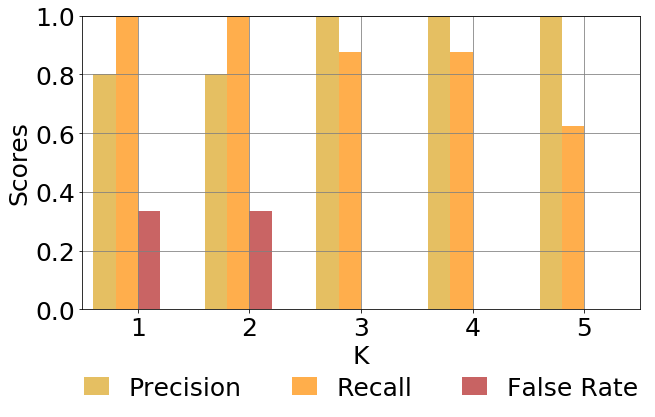

In [11]:
results = {}
results[node] = statistics.getNodeResult(df, times, kMAX=5)
statistics.getPrecisionRecallFalseRate(results, kMAX=5, plot=True)

As you can see, in this specific case, with these parameters, the algorithm produces exactly 0 false positives for DOK=5. On the other hand there is the need to wait 5 consecutive samples before raising (increasing delay).

#### Step 4: Re-Run on all the nodes
We can run the algorithm again considering all the nodes and see how the algorithm performs globally.

(array([[  1.07578125,   0.81569318,   6.07477778],
        [  2.15015625,   1.98103409,   7.33811111],
        [  6.72359375,   6.79685366,   7.07797115],
        [  8.34359375,  10.73130469,   9.32785937],
        [  9.42046875,  13.67443   ,  12.59073077]]),
 {'hop0': array([ 0.00604356,  0.00596823,  2.23871425,  2.53619915,  2.53608011]),
  'hop1': array([ 0.12726607,  0.15227952,  1.37028105,  1.06407524,  2.92873103]),
  'hop2': array([ 3.74481798,  3.73727675,  1.90163689,  2.8956138 ,  5.20373828])})

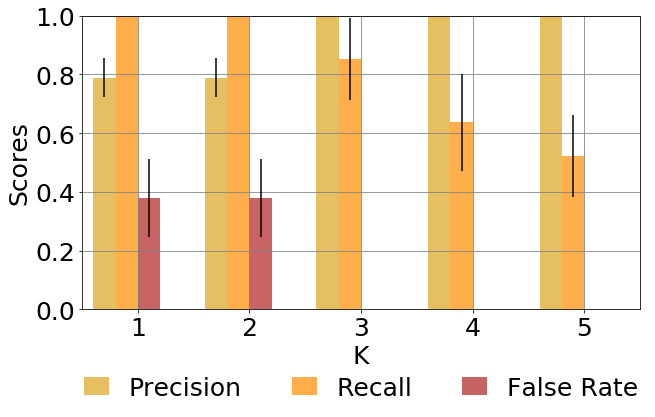

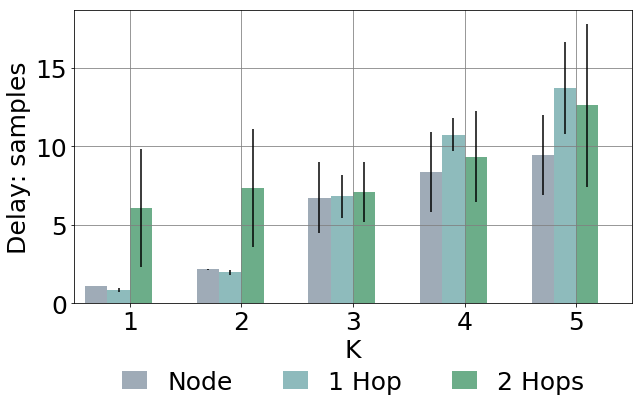

In [13]:
nodes = ['leaf1', 'leaf2', 'leaf3', 'leaf5', 'leaf6', 'leaf7', 'leaf8',\
         'spine1', 'spine2', 'spine3', 'spine4']

results = {}

for node in nodes:

    df = pd.read_csv('Data/'+node+'clear_bgp.csv').dropna()\
        .drop('Unnamed: 0', axis=1)

    deleteFeatureList = []
    
    for columnName in df.columns:
        if 'rate' in columnName:            
            deleteFeatureList.append(columnName)
        if 'load' in columnName:            
            deleteFeatureList.append(columnName)

    df = df.drop(deleteFeatureList, axis=1)

    times = df['time']
    df = df.drop(['time'], axis=1)

    dfNormalized = normalize_matrix(df).dropna(axis=1)

    sampleSkip = 40
    bufferDf = dfNormalized[0:sampleSkip]
    testDf = dfNormalized[sampleSkip:]

    den = DenStream(lamb=0.03, epsilon='auto', beta=0.03, mu='auto', startingBuffer=bufferDf, tp=36)
    den.runInitialization()

    outputCurrentNode = []
    for sampleNumber in range(len(testDf)):
        sample = testDf.iloc[sampleNumber]
        result = den.runOnNewSample(Sample(sample.values, times.iloc[sampleNumber]))
        outputCurrentNode.append(result)
    ### END SIMULATION ###

    df['result'] = [False] * sampleSkip + outputCurrentNode

    truth = groundTruth()
    truth.simulationBGP_CLEAR_Second_DATASET()
    truth.simulationBGP_CLEAR2_CLEAR()

    statistics = Statistics(node, truth)
    results[node] = statistics.getNodeResult(df, times, kMAX=5)

statistics.getPrecisionRecallFalseRate(results, kMAX=5, plot=True)
statistics.getDelay(results, kMAX=5, plot=True, samplingRate=4)

#### Results
The Dataset in use it is available at https://github.com/cisco-ie/telemetry